# Newsgroups

In order to practice and learn to work with text data, let's use the 20 Newsgroups archive.

Things we're going to do:
- get the data
- work with some feature extraction
- develop a model that can classify the Newsgroups
- Investigate the results of unsupervised clustering models on this group.

In [1]:
## import essentials and anticipated packages

import numpy as np
import pandas as pd
import re

from sklearn.datasets import fetch_20newsgroups

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.kernel_approximation import Nystroem #I need to read up on this. It was not helpful out-of-box.

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
#%matplotlib notebook

In [2]:
train = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'),subset='train')
test = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'),subset='test')

In [3]:
## What's the distribution like?

## check that I know how the data is structured.
print(train.data[7][:100]) ##this is such a newsgroup discussion about comptuers


## set as Pandas objects for easier access and manipulation
y_train = pd.Series(train.target)
y_test = pd.Series(test.target) 
X_train = pd.DataFrame(train.data)
X_test = pd.DataFrame(test.data)

## check skew in data
print(y_train.value_counts())
print(y_train.value_counts()/y_train.value_counts().mean())#not particularly skew


##A dictionary of the topics for ease of reference.
train.target_names
target_names_dict = { i : train.target_names[i] for i in range(0,20)}

                                                                      
ALL this shows is that YOU do
10    600
15    599
8     598
9     597
11    595
13    594
7     594
14    593
5     593
12    591
2     591
3     590
6     585
1     584
4     578
17    564
16    546
0     480
18    465
19    377
dtype: int64
10    1.060633
15    1.058865
8     1.057097
9     1.055330
11    1.051794
13    1.050027
7     1.050027
14    1.048259
5     1.048259
12    1.044723
2     1.044723
3     1.042956
6     1.034117
1     1.032349
4     1.021743
17    0.996995
16    0.965176
0     0.848506
18    0.821990
19    0.666431
dtype: float64


In [4]:
## set up some reporting tools which we will use to evaluate models.

import matplotlib.pyplot as plt
import seaborn

## matplotlib confusion matrix
def draw_confusion_matrix(clf,X,y,predicted = False,title="Confusion Matrix"):
    ''' 
    Draws a nice looking confusion matrix for a classifier, given features X and target y
    '''
    if not predicted:
        X = clf.predict(X)
    confusion = confusion_matrix(y, X)
    df_confusion = pd.DataFrame(confusion, index = [i for i in range(0,len(y.unique()))],
                      columns = [i for i in range(0,len(y.unique()))]).astype(int)
    plt.figure()
    seaborn.heatmap(df_confusion, annot=False)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## A short evaluation report.    
def report_clf_evals(clf,X,y,predicted=False):
    '''
    Produces text summary and confusion matrix graphic of clf.
    '''
    actual=y
    if not predicted:
        predicted = clf.predict(X)
    else:
        predicted = X
    print('  Accuracy: {:.4f}'.format(accuracy_score(actual, predicted)))
    print('  Precision: {:.4f}'.format(precision_score(actual, predicted, average='macro')))
    print('  Recall: {:.4f}'.format(recall_score(actual, predicted, average='macro')))
    print('  F1: {:.4f}'.format(f1_score(actual, predicted, average='macro')))
    #print(confusion_matrix(actual,predicted))
    draw_confusion_matrix(clf,predicted,actual,predicted=True)

## Part 2

Now we've established some features. Time to build models and see what works. 

We begin with Multinomial Bayes and a bag of words.

In [5]:
col_trans = ColumnTransformer([('vectorizer', CountVectorizer(), 'text')
                                ])

count_bayes_clf = Pipeline(steps= [
                        ('column_transformer', col_trans),
                        ('multinomial_bayes', MultinomialNB())
                        ]
                        )


In [ ]:
count_bayes_clf.fit(X_train,y_train)
report_clf_evals(count_bayes_clf,X_train,y_train)

In [ ]:
report_clf_evals(count_bayes_clf,X_test,y_test)


In [6]:
k_fold = KFold(n_splits=2) ##we're still looking for gross differences, not fine tuning. 

parameters = {
    'column_transformer__vectorizer__ngram_range' :[(1,1),(1,2),(1,3),(2,2)]
}

grid_search = GridSearchCV(count_bayes_clf, parameters, cv=k_fold, return_train_score=True)

In [ ]:
grid_search.fit(X_train,y_train)
grid_search.cv_results_

In [7]:
parameters = {
    #'column_transformer__vectorizer__ngram_range' :[(1,1),(1,2),(1,3),(2,2)]
    'multinomial_bayes__alpha':[.005,.01,.03] ## alpha higher than 1 reduced train and test scores
}
k_fold.n_splits = 5 ## seemed to be a pretty robust result in favor of reducing alpha.
grid_search = GridSearchCV(count_bayes_clf, parameters, cv=k_fold, return_train_score=True)
#

In [ ]:
grid_search.fit(X_train,y_train)
grid_search.cv_results_

In [8]:
parameters = {
    'column_transformer__vectorizer__stop_words' :[None,'english'],
    'multinomial_bayes__alpha':[.01] ## alpha close to zero is better than close to 1.
}
k_fold.n_splits = 2 ## seemed to be a pretty robust result in favor of reducing alpha.
grid_search = GridSearchCV(count_bayes_clf, parameters, cv=k_fold, return_train_score=True)

In [ ]:
grid_search.fit(X_train,y_train)
grid_search.cv_results_

In [9]:
## Our strongest Bayesian model with a count vectorizer is very close to this.
count_vect = CountVectorizer(ngram_range=(1,3), stop_words='english')

col_trans = ColumnTransformer([('vectorizer', count_vect, 'text')
                                ])

count_bayes_clf = Pipeline(steps= [
                        ('column_transformer', col_trans),
                        ('multinomial_bayes', MultinomialNB(alpha=.01))
                        ]
                        )

In [ ]:
count_bayes_clf.fit(X_train,y_train)
report_clf_evals(count_bayes_clf, X_test, y_test)

## Part 3: tf-idf

Notice that the grid search results were a lot stronger than the test results. They aren't from the same distribution; the train and test sets are split by date, not randomly. This makes it a nice real-world case.

In [10]:
## Let's inspect a tfidf vectorizer inplace of the bag-of-words approach.

tfidf_vect = TfidfVectorizer()

col_trans = ColumnTransformer([#('vectorizer', count_vect, 'text'),
                                ('vectorizer', tfidf_vect, 'text')
                                ])

bayes_tfidf_clf = Pipeline(steps= [
                        ('column_transformer', col_trans),
                        ('multinomial_bayes', MultinomialNB())
                        ]
                        )


In [11]:
## Let's run the same three search, but define them all at once.
k_fold = KFold(n_splits=2) 

parameters = {
    'multinomial_bayes__alpha':[.01,.03,.1,1] ## alpha higher than 1 reduced train and test scores
}
alpha_search = GridSearchCV(bayes_tfidf_clf, parameters, cv=k_fold, return_train_score=True)

parameters = {
    #'column_transformer__vectorizer__ngram_range' :[(1,1),(1,2),(1,3),(2,2)].
    'multinomial_bayes__alpha':[.03], ## alpha higher than 1 reduced train and test scores
    'column_transformer__vectorizer__stop_words' :[None,'english']
}
stop_word_search = GridSearchCV(bayes_tfidf_clf, parameters, cv=k_fold, return_train_score=True)

parameters = {
    'multinomial_bayes__alpha':[.03], ## using default (=1), the below is just all around weak on test sets.
    'column_transformer__vectorizer__stop_words' :['english'],
    'column_transformer__vectorizer__ngram_range' :[(1,1),(1,2),(1,3),(2,2)]
}
ngram_search = GridSearchCV(bayes_tfidf_clf, parameters, cv=k_fold, return_train_score=True)

In [ ]:
alpha_search.fit(X_train,y_train)
alpha_search.cv_results_

In [ ]:
stop_word_search.fit(X_train,y_train)
stop_word_search.cv_results_

In [ ]:
ngram_search.fit(X_train,y_train)
ngram_search.cv_results_

In [12]:
parameters = {
    'multinomial_bayes__alpha':[.01,.03], ## using default (=1), the below is just all around weak on test sets.
    'column_transformer__vectorizer__stop_words' :['english'],
    'column_transformer__vectorizer__ngram_range' :[(1,1),(1,2),(1,3)]
}
k_fold.n_splits = 3
final_search = GridSearchCV(bayes_tfidf_clf, parameters, cv=k_fold, return_train_score=True)

In [ ]:
final_search.fit(X_train,y_train)
final_search.cv_results_

In [ ]:

tfidf_vect.ngram_range = (1,2)
tfidf_vect.stop_words = 'english'
col_trans = ColumnTransformer([#('vectorizer', count_vect, 'text'),
                                ('vectorizer', tfidf_vect, 'text')
                                ])

bayes_tfidf_clf = Pipeline(steps= [
                        ('column_transformer', col_trans),
                        ('multinomial_bayes', MultinomialNB(alpha = .01))
                        ]
                        )

In [ ]:
bayes_tfidf_clf.fit(X_train,y_train)
report_clf_evals(bayes_tfidf_clf,X_test,y_test)

## Step 4: SVC Classifier

In [13]:
scale_cols = ['text length'] ##the columns value in the column transformer needs a list
col_trans = ColumnTransformer([('scaler', StandardScaler(),scale_cols),
                                ('vectorizer', tfidf_vect, 'text')
                                ])
svc_clf = Pipeline(steps=[('col_transformer',col_trans),
                            ('svc_clf',SVC())])


In [ ]:
#svc_clf.fit(X_train.sample(300,random_state=1),y_train.sample(300,random_state=1)) #fast version, for debugging
#report_clf_evals(svc_clf,X_test.sample(300,random_state=1),y_test.sample(300,random_state=1))#fasterm for debugging

## NOPE!
## SVC is a fun idea, but it's remarkably slow with 12,000 training samples.
see_how_slow = False
if see_how_slow:
    svc_clf.fit(X_train,y_train)
    report_clf_evals(svc_clf,X_train,y_train)
    report_clf_evals(svc_clf,X_test,y_test)

In [14]:
from sklearn.kernel_approximation import Nystroem

scale_cols = ['text length'] ##the columns value in the column transformer needs a list
col_trans = ColumnTransformer([('scaler', StandardScaler(),scale_cols),
                                ('vectorizer', tfidf_vect, 'text'),
                                ])
sgd_clf = Pipeline(steps=[('col_transformer',col_trans),
                            #('kernel_approximator',Nystroem()),
                            ('sgd_clf',SGDClassifier())])

In [ ]:
sgd_clf.fit(X_train,y_train)
report_clf_evals(sgd_clf,X_train,y_train)
report_clf_evals(sgd_clf,X_test,y_test)

In [15]:


parameters = {'sgd_clf__alpha':[.0001,.001,.01,.1]}

k_fold.n_splits = 2
sgd_grid = GridSearchCV(sgd_clf,parameters,cv = k_fold, return_train_score=True)

In [ ]:
sgd_grid.fit(X_train,y_train)
sgd_grid.cv_results_

### Comment

The multinomial baysian classifier is the best so far; it has the highest score (by a very small, possibly insignificant) margin but trains fastest. I'm going to try an MLP just because I think it would be a mistake not to, but I suspect we have too many features relative to total data (~600 samples per class) for it to work well.

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_clf = Pipeline(steps=[('col_transformer',col_trans),
                            #('kernel_approximator',Nystroem()),
                            ('mlp_clf', MLPClassifier(hidden_layer_sizes=(20),
                                        learning_rate_init=.03,
                                        batch_size=128))])

In [ ]:
mlp_clf.fit(X_train,y_train)
report_clf_evals(mlp_clf,X_train,y_train)
report_clf_evals(mlp_clf,X_test,y_test)


In [ ]:

parameters = {
                'mlp_clf__alpha':[.0001,.001,.01],
                'mlp_clf__hidden_layer_sizes': [8]}
mlp_search = GridSearchCV(mlp_clf,parameters,cv = k_fold, return_train_score=True)

In [ ]:
mlp_search.fit(X_train,y_train)
mlp_search.cv_results_

## More Features

As expected, the MLP is a processor intesive exercise in low performance. But the overall performance of our models isn't all that strong. I would like to add some features and try some tricks.

- Digit and numeric expression counts for texts.
- Stemming/Lemmatization

In [16]:
## Let's make the length of the message a feature.
X_train2 = X_train.copy()
X_test2 = X_test.copy()
for df in (X_train2, X_test2):
    df.rename({0:'text'}, axis=1, inplace=True)
    df['text length'] = df['text'].apply(lambda x: len(x))


In [ ]:
## Let's see if that's any info at all. 
quick_clf = MultinomialNB(alpha=.01)
quick_clf.fit(X_train2.drop('text',axis=1),y_train)
report_clf_evals(quick_clf,X_train2.drop('text', axis=1),y_train)
## This appears to have no effect on classification.

In [ ]:
## Science and sports may 
## have more numbers than atheism, politics or religion, for example of why. Do not match currency expressions.


## The following expression was is good r'(?<=\s)[1-9][\d]{0,2}[(,?\d{3})*|(\d)*]*\.?\d*'
numeric_expression = r'(?<=\s)[1-9][\d]{0,2}[(,?\d{3})*|(\d)*]*\.?\d*'##digits, optional commas, optional decimal (one)

## https://stackoverflow.com/questions/5917082/regular-expression-to-match-numbers-with-or-without-commas-and-decimals-in-text
#numeric_expression = r'(?<!\S)(\d*\.?\d+|\d{1,3}(,\d{3})*(\.\d+)?)(?!\S)' ##
# I like mine better. Grouping is annoying in this context.

## Test set to see that we're matching and not matching correct stuff.
#print(re.findall(numeric_expression,'1 12 1,234,567 4010020030 4,000 3.14159'))#we want to match all of these
#print(re.findall(numeric_expression, 'catch22 $123 $3.14')) #but don't match these

X_train2['numeric expression count'] = X_train2['text'].apply(lambda x: len(re.findall(numeric_expression,x)))
X_test2['numeric expression count'] = X_test2['text'].apply(lambda x: len(re.findall(numeric_expression,x)))


In [ ]:
## Let's see if that's any info at all. 
quick_clf = MultinomialNB(alpha=.01)
quick_clf.fit(X_train2.drop('text',axis=1),y_train)
report_clf_evals(quick_clf,X_train2.drop('text', axis=1),y_train)

## It's hardly enough to make things accurate. But
## this is information: it clearly changes how things are categorized. 


In [ ]:
## Let's add a currency expression feature. 
## It would be better to include pound symbols and stuff like that.
currency_expression = r'\$[1-9][\d]{0,2}[(,?\d{3})*|(\d)*]*\.?\d*'##digits, optional commas, optional decimal (one)

contains_ce = ' $3.14, $300, $4,499, $1,001,350.10 $500000000000'
contains_no_ce = '3.14159, 11.2.2020,'
#print(re.findall(currency_expression,contains_ce))
#print(re.findall(currency_expression,contains_no_ce))

X_train2['currency expression count'] = X_train2['text'].apply(lambda x: len(re.findall(currency_expression,x)))
X_test2['currency expression count'] = X_test2['text'].apply(lambda x: len(re.findall(currency_expression,x)))
## Let's see if that's any info at all. 
quick_clf = MultinomialNB(alpha=.01)
quick_clf.fit(X_train2.drop('text',axis=1),y_train)
report_clf_evals(quick_clf,X_train2.drop('text', axis=1),y_train)

## each of these features makes a small improvement.

In [ ]:
## Exponentials are scientific jargon...

exponential_expression = r'\^\-?[.\d]+'
contains_exp_exp = '3.00x10^8  10^-9, 2^.5'##This variable name shows that I'm getting a little punchy.
re.findall(exponential_expression,contains_exp_exp)

X_train2['exponential expression count'] = X_train2['text'].apply(lambda x: len(re.findall(exponential_expression,x)))
X_test2['exponential expression count'] = X_test2['text'].apply(lambda x: len(re.findall(exponential_expression,x)))
## Let's see if that's any info at all. 
quick_clf = MultinomialNB(alpha=.01)
quick_clf.fit(X_train2.drop('text',axis=1),y_train)
report_clf_evals(quick_clf,X_train2.drop('text', axis=1),y_train)

In [ ]:
tfidf_vect.ngram_range = (1,2)
tfidf_vect.stop_words = 'english'
col_trans = ColumnTransformer([#('vectorizer', count_vect, 'text'),
                                ('vectorizer', tfidf_vect, 'text')
                                ], remainder='passthrough')

bayes_tfidf_clf = Pipeline(steps= [
                        ('column_transformer', col_trans),
                        ('multinomial_bayes', MultinomialNB(alpha = .001))
                        ]
                        )
bayes_tfidf_clf.fit(X_train2,y_train)

In [ ]:
report_clf_evals(bayes_tfidf_clf,X_train2,y_train)
report_clf_evals(bayes_tfidf_clf,X_test2,y_test)

In [ ]:
scale_cols = X_train2.select_dtypes(int).columns ##the columns value in the column transformer needs a list
col_trans2 = ColumnTransformer([('scaler', StandardScaler(),scale_cols),
                                ('vectorizer', tfidf_vect, 'text'),
                                ], 
                                remainder='passthrough')
sgd_clf = Pipeline(steps=[('col_transformer',col_trans2),
                            #('kernel_approximator',Nystroem()),
                            ('sgd_clf',SGDClassifier())])
sgd_clf.fit(X_train2,y_train)

In [ ]:
report_clf_evals(sgd_clf,X_train2,y_train)
report_clf_evals(sgd_clf,X_test2,y_test)

## Lemmatize? 

I want to check if lemmatizing has any benefit. I'm going to set up a lemmatizer and see if I get a noteworthy performance jump. I don't really anticipate that and the computational costs (large) probably outweigh benefitis. However, this might have an effect that worth capturing.

### Comment on more features

Those features mostly seemed to bias the classifier toward misclassifying some docs as coming from "mathy" subject. There was no performance increase. You can't usually predict the effect of adding features...

In [19]:
import nltk
from nltk import WordNetLemmatizer, pos_tag, pos_tag_sents, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer, PorterStemmer
from collections import defaultdict

test_string = "The Big Lebowski is the funniest movie I have ever seen. I have been watching it yearly since I saw it in the theatre the year it was released." ## used to make sure we're gettting desired results.

lemmatizer = WordNetLemmatizer()
#print(pos_tag(word_tokenize(test_string)),'\n\n')

## set up a mapper. Just in case we get a 
pos_map = defaultdict(lambda: 'n') ##if the key is not found, assumes noun.
pos_map['J'] = wordnet.ADJ
pos_map['N'] = wordnet.NOUN
pos_map['V'] = wordnet.VERB
pos_map['R'] = wordnet.ADV 
 

def pos_tag_as_wn(word_list,map):
    """ 
    Returns a (string, pos) tuple from a list of words. The pos is a string
    that has the value of a wordnet POS tag.
    """
    return [(w[0],map[w[1][0]]) for w in pos_tag(word_list)]

[lemmatizer.lemmatize(w[0], w[1]) for w in pos_tag_as_wn(word_tokenize(test_string),pos_map)][9:14]

['ever', 'see', '.', 'I', 'have']

In [ ]:
## Checking speed of defaultdict
## Usually, python stuff is pretty optimized, but I wondered whether a default dict would 
## be faster than just using dict.setdefault()
import time
start = time.time()
for i in range(100_000):
    for e in 'JNVRA':
        pos_map[e]
end = time.time()
print(end-start)
temp = {'J':'a','N':'n','V':'v','R':wordnet.ADV}
start = time.time()
for i in range(100_000):
    for e in 'JNVRA':
        temp.setdefault(e,'n')
end = time.time()
print(end-start)
## Default dict is fast!

In [20]:
def lemmatizing_tokenizer(text):
    '''
    Returns lemmatized string lists given a text to lemmatize, i.e. gives the lemmatized tokens in text.

    This is a very slow operation for a large number of docs; pos_tag is comp expensive. 
    I was mostly concerned to see if lemmatizing helped. If it had, I would work out a solution with pos_tag_sent, which (I hope) would     give some performance benefit. 
    '''
    return [lemmatizer.lemmatize(w[0], w[1]) for w in pos_tag_as_wn(word_tokenize(text),pos_map)]

In [31]:
X_train.rename({0: 'text'}, axis=1, inplace=True)
X_test.rename({0: 'text'}, axis=1, inplace=True)

tfidf_vect.ngram_range = (1,2)
tfidf_vect.tokenizer = None
tfidf_vect.stop_words = 'english'
col_trans = ColumnTransformer([#('vectorizer', count_vect, 'text'),
                                ('vectorizer', tfidf_vect, 'text')
                                ], remainder='passthrough')

bayes_tfidf_clf = Pipeline(steps= [
                        ('column_transformer', col_trans),
                        ('multinomial_bayes', MultinomialNB(alpha = .001))
                        ]
                        )


  Accuracy: 0.6981
  Precision: 0.6973
  Recall: 0.6869
  F1: 0.6862


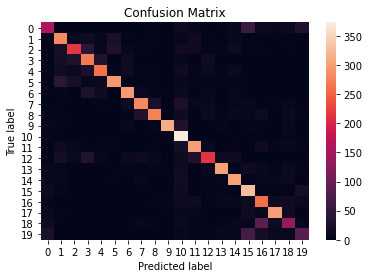

In [32]:
## very slow... you can see the benefits if you really want
if False: # set to true if you want to see
    bayes_tfidf_clf.fit(X_train,y_train)
    report_clf_evals(bayes_tfidf_clf,X_test,y_test)

In [30]:
## I saved the result in case I ever really wanted it.

import pickle
pickle_out = open('bayes__clf.pickle','wb')
pickle.dump(bayes_tfidf_clf,pickle_out)

### Comment

There's no clear gain from lemmatizing, unless you count what you learned about nltk.

## But what are we learning?

Perhaps we will find a better classifier, perhaps not. Let's assume that our classifier is finding real similarities; What do we learn from this classifier? 

In [38]:
predictions = bayes_tfidf_clf.predict(X_test)


In [114]:
matrix = confusion_matrix(y_test,predictions)
fmt_string = '{:18} ({:2})  {:.1f}  {:.1f} {}'
print('{:24} {:4}  {:4}'.format('Category','cor','incor'))
# print(matrix[0,:])
for i in range(0,20):
    cat = target_names_dict[i]
    cat = cat[0:min(len(cat),18)]
    total = matrix[i,:].sum()
    correct = matrix[i,i]/total*100
    incorrect = 100 - correct
    miscat = list(np.delete(matrix[i,:], [i]))
    miscat_ind = miscat.index(max(miscat))
    miscat = target_names_dict[miscat_ind] if miscat_ind < i else target_names_dict[miscat_ind+1]
    print(fmt_string.format(cat, i, correct, incorrect, miscat))


Category                 cor   incor
alt.atheism        ( 0)  49.8  50.2 soc.religion.christian
comp.graphics      ( 1)  72.8  27.2 comp.windows.x
comp.os.ms-windows ( 2)  55.3  44.7 comp.sys.ibm.pc.hardware
comp.sys.ibm.pc.ha ( 3)  69.1  30.9 comp.sys.mac.hardware
comp.sys.mac.hardw ( 4)  68.1  31.9 comp.sys.ibm.pc.hardware
comp.windows.x     ( 5)  74.7  25.3 comp.graphics
misc.forsale       ( 6)  75.9  24.1 comp.sys.ibm.pc.hardware
rec.autos          ( 7)  71.2  28.8 rec.motorcycles
rec.motorcycles    ( 8)  69.1  30.9 rec.autos
rec.sport.baseball ( 9)  78.8  21.2 rec.sport.hockey
rec.sport.hockey   (10)  93.5  6.5 rec.sport.baseball
sci.crypt          (11)  75.5  24.5 rec.sport.hockey
sci.electronics    (12)  54.2  45.8 comp.sys.ibm.pc.hardware
sci.med            (13)  76.5  23.5 rec.sport.hockey
sci.space          (14)  77.2  22.8 rec.sport.hockey
soc.religion.chris (15)  82.9  17.1 talk.religion.misc
talk.politics.guns (16)  71.4  28.6 talk.politics.misc
talk.politics.mide (17)  79

### Thoughts

It's fun to see when things seem to work: notice how similar the most frequent misclassification is: atheism classifies as religion.christianity; the sports are mistaken for one another; science electronics sometimes looks like ibm.pc hardware.

#### Hocky?

I would not have guessed that hockey would be so strong. By the way, it is also the number one source of false positives. Why so many classifications as hocky? 

#### A weaker classification scheme?

The results certainly suggest that you could get a pretty good classifier on this data that's "Sports or Politics or Science." I might try that sometime.